# Gap opening figure

In [8]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from munch import munchify

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [9]:
import numpy as np
from time import time
from operator import mul
from functools import reduce
from itertools import count
from munch import Munch
from itertools import zip_longest
import logging
import multiprocessing as mp

import re
from pathlib import Path

import scipy
from FKMC.general import index_histogram_array, sort_IPRs, smooth, shapes, normalise_IPR
from FKMC.import_funcs import shape_hints, timefmt

from FKMC.import_funcs import  mean_over_MCMC, IPRandDOS, extract, get_data_funcmap_chain_ext
from FKMC.import_funcs import incremental_get_data_funcmap_chain_ext, incremental_load

In [10]:

plt.rc('font', family='sans-serif')
plt.rc('figure', dpi=200) #makes the plots display larger in the jupyter view
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8, direction='in', bottom=True, top=True)
plt.rc('ytick', labelsize=8, direction='in', left=True, right=True)
plt.rc('axes', labelsize=8)
plt.rc('figure', autolayout=False)

from matplotlib.colors import to_rgba

colors = list(map(to_rgba, """
#55115c
#821760
#ab275e
#cd4158
#e7624f
#f88646
#ffad40
#ffd547
""".strip().split('\n'))) #https://learnui.design/tools/data-color-picker.html#palette

colors10 = list(map(to_rgba, """
#55115c
#7d1560
#a1225f
#c1375b
#db5154
#eb694d
#f78347
#fe9d42
#ffb941
#ffd547
""".strip().split('\n'))) #https://learnui.design/tools/data-color-picker.html#palette

#make a colormap from the colors
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list("mycmap", colors)

In [5]:
%%time
functions = [
    mean_over_MCMC('Mf_moments', N_error_bins = 10),
    IPRandDOS(),
]
o1 = incremental_load(folder = '~/HPC_data/gap_open_U=2', functions = functions, force_reload = False)
print(o1.Ts)

DEBUG:FKMC.import_funcs:todo: [141, 142]
DEBUG:FKMC.import_funcs:/rds/general/user/tch14/home/HPC_data/gap_open_U=2/data/141_0.npz is only partially finished.
DEBUG:FKMC.import_funcs:/rds/general/user/tch14/home/HPC_data/gap_open_U=2/data/142_0.npz is only partially finished.
INFO:FKMC.import_funcs:########################################################################

INFO:FKMC.import_funcs:Observables has keys: dict_keys(['flat', 'hints', 'processed_task_ids', 'this_run', 'datapath', 'codepath', 'py_script', 'batch_params', 'structure_names', 'structure_dims', 'N_tasks', 'chains', 'N_chains', 'original_N_steps', 'thin', 'N_steps', 'E_bins', 'Ns', 'parameters', 'MCMC_params', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'Rs', 'Ts', 'Mf_moments', 'DOS', 'IPR', 'dDOS', 'dIPR', 'time', 'accept_rates', 'proposal_rates', 'functions'])
INFO:FKMC.import_funcs:    Completed jobs:?
    MCMC Steps: 1 chains of 5000 for 5000 with thinning = 10 for 500 recorded steps
 

141 142 [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6
 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5. ]
CPU times: user 213 ms, sys: 882 ms, total: 1.09 s
Wall time: 1.98 s


In [134]:
%%time
functions = [
    mean_over_MCMC('Mf_moments', N_error_bins = 10),
    IPRandDOS(),
]
o2 = incremental_load(folder = '~/HPC_data/gap_opening_U=2_low_temp', functions = functions, force_reload = False)

DEBUG:FKMC.import_funcs:todo: []
INFO:FKMC.import_funcs:########################################################################

INFO:FKMC.import_funcs:Observables has keys: dict_keys(['flat', 'hints', 'processed_task_ids', 'this_run', 'datapath', 'codepath', 'py_script', 'batch_params', 'structure_names', 'structure_dims', 'N_tasks', 'chains', 'N_chains', 'original_N_steps', 'thin', 'N_steps', 'E_bins', 'Ns', 'parameters', 'MCMC_params', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'Rs', 'Ts', 'Mf_moments', 'DOS', 'IPR', 'dDOS', 'dIPR', 'time', 'accept_rates', 'proposal_rates', 'functions'])
INFO:FKMC.import_funcs:    Completed jobs:?
    MCMC Steps: 5 chains of 5000 for 25000 with thinning = 10 for 2500 recorded steps
    Burn in: 5000
    Structure_names: {'Rs': 5, 'Ts': 10}
    Ns = [ 60. 120. 270.]
    Runtimes: 
        Average: 1.0 hours
        Min: 1.0 hours
        Max: 3.0 hours
        Total: 3.0 days
    
    


CPU times: user 86.4 ms, sys: 961 ms, total: 1.05 s
Wall time: 4.19 s


In [6]:
%%time
functions = [
    mean_over_MCMC('Mf_moments', N_error_bins = 10),
    IPRandDOS(),
]
olog = incremental_load(folder = '~/HPC_data/gap_opening_logarithmic', functions = functions, force_reload = False)

INFO:FKMC.import_funcs:looking in /rds/general/user/tch14/home/HPC_data/gap_opening_logarithmic
DEBUG:FKMC.import_funcs:structure_names = ['Rs', 'Ts']
DEBUG:FKMC.import_funcs:structure_dims = (5, 7)


[PosixPath('/rds/general/user/tch14/home/HPC_data/gap_opening_logarithmic/code/gap_opening_logarithmic.py')]
Ham_params:  t=1, alpha=1.25, mu=0, beta=varying, J=5, U=2, normalise=True,


Tasks per chain: 5,

Each doing 5000 steps,

25000 total chain length,

2500 samples,


MCMC_params:  N_steps=5000, N_burn_in=5000, thin=10, proposal=<function p_multi_site_uniform_reflect at 0x2af0a11e37a0>, accept_function=<function perturbation_accept at 0x2af0a11e5a70>, warnings=False,


ValueError: max() arg is an empty sequence

In [135]:
from scipy.stats import sem
from FKMC.plotting import spread
from FKMC.general import scaling_dimension
import multiprocessing as mp

def interpolate_IPR(E_bins, unsmoothed_DOS, IPR, dIPR):
    newshape = (IPR.size // IPR.shape[-1], IPR.shape[-1])
    _DOS = unsmoothed_DOS.reshape(newshape)
    _IPR = IPR.reshape(newshape)
    _dIPR = dIPR.reshape(newshape)
    
    for i, DOS, I, dI in zip(count(), _DOS, _IPR, _dIPR):
        ei = DOS > 0
        if any(ei):
            _I = I[ei]
            _dI = dI[ei]
            xI = E_bins[1:][ei]

            _IPR[i] = np.interp(E_bins[1:], xI, _I)
            _dIPR[i] = np.interp(E_bins[1:], xI, _dI)
        else:
            _IPR[i] = E_bins[1:] * np.NaN
            _dIPR[i] = E_bins[1:] * np.NaN

def fit_errors(X, Y, dY):
    try:
        (m, c), cov = np.ma.polyfit(X, Y, deg = 1, cov=True, w = 1 / dY)
        dm, dc = np.sqrt(np.diag(cov))
        return m, c, dm, dc
    except np.linalg.LinAlgError:
        return np.NaN, np.NaN, np.NaN, np.NaN

def fit_no_errors(X, Y):
    try:
        (m, c), cov = np.ma.polyfit(X, Y, deg = 1, cov=True)
        dm, dc = np.sqrt(np.diag(cov))
        return m, c, dm, dc
    except np.linalg.LinAlgError:
        return np.NaN, np.NaN, np.NaN, np.NaN

def scaling_dimension_multidim(Ns, IPR, dIPR, use_true_errors = True):
    original_shape = IPR.shape
    newshape = (IPR.shape[0], IPR.size // IPR.shape[0])
    finalshape = IPR.shape[1:]
    IPR = IPR.reshape(newshape)
    dIPR = dIPR.reshape(newshape)
    print(original_shape, newshape, finalshape)
    
    Y = np.log(IPR).T
    dY = dIPR.T / IPR.T #take the maximum error across the energy spectrum because we can't do it individually
    #set a minimum 5% error
    dY = np.maximum(dY, 5/100)
    X = np.broadcast_to(np.log(Ns), Y.shape)
    
    with mp.Pool(16) as pool:
        if use_true_errors:
            args = np.stack([X, Y, dY], axis = 1)
            fit = fit_errors
        else:
            args = np.stack([X, Y, dY], axis = 1)
            fit = fit_no_errors
        
        print(args.shape)
        m, c, dm, dc = np.array(pool.starmap(fit, args, chunksize = 1000)).T
                                    
    
    #m, c, dm, dc = np.full(fill_value = np.NaN, shape = (4,newshape[1]))
    #for i in range(Y.shape[1]):
    
    return m.reshape(finalshape), c.reshape(finalshape), dm.reshape(finalshape), dc.reshape(finalshape)

if len(o1.IPR.shape) == 4:
    assert(all(o1.Ts[:10] ==  o2.Ts)) #assert that 02 just fills in the lower T data of o1
    for name in ['IPR', 'DOS']:
        o1[name][:, :, :10, :] = o2[name]

for o in [
    o1,
        ]:
    if len(o.IPR.shape) == 4:
        interpolate_IPR(o.E_bins, unsmoothed_DOS=o.DOS, IPR=o.IPR, dIPR=o.dIPR)
        
        o.dIPR = sem(o.IPR, axis = 1)
        o.IPR = np.mean(o.IPR, axis = 1)
        o.dDOS = sem(o.DOS, axis = 1)
        o.DOS = np.mean(o.DOS, axis = 1)
        
        o.IPR = smooth(o.IPR, scale = 0.5, axis = -1)
        o.dIPR = smooth(o.dIPR, scale = 0.5, axis = -1)
        o.DOS = smooth(o.DOS, scale = 0.5, axis = -1)
        
        o.m, o.c, o.dm, o.dc = scaling_dimension_multidim(o.Ns, o.IPR, o.dIPR, use_true_errors = True)
    else:
        print('smoothing already done')
        
with open('/home/tch14/HPC_data/pickled_data/gap_opening.pickle', 'wb') as file:
    pickle.dump(o1, file)
    
#with open('/home/tch14/HPC_data/pickled_data/gap_opening_low_temp.pickle', 'wb') as file:
#    pickle.dump(o2, file)
    
print('Done!!')

/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


(3, 50, 2000) (3, 100000) (50, 2000)
(100000, 3, 3)
Done!!


In [125]:
o1.hints.IPR

('Ns', 'Rs', 'Ts', 'energy index')

NameError: name 'spread' is not defined

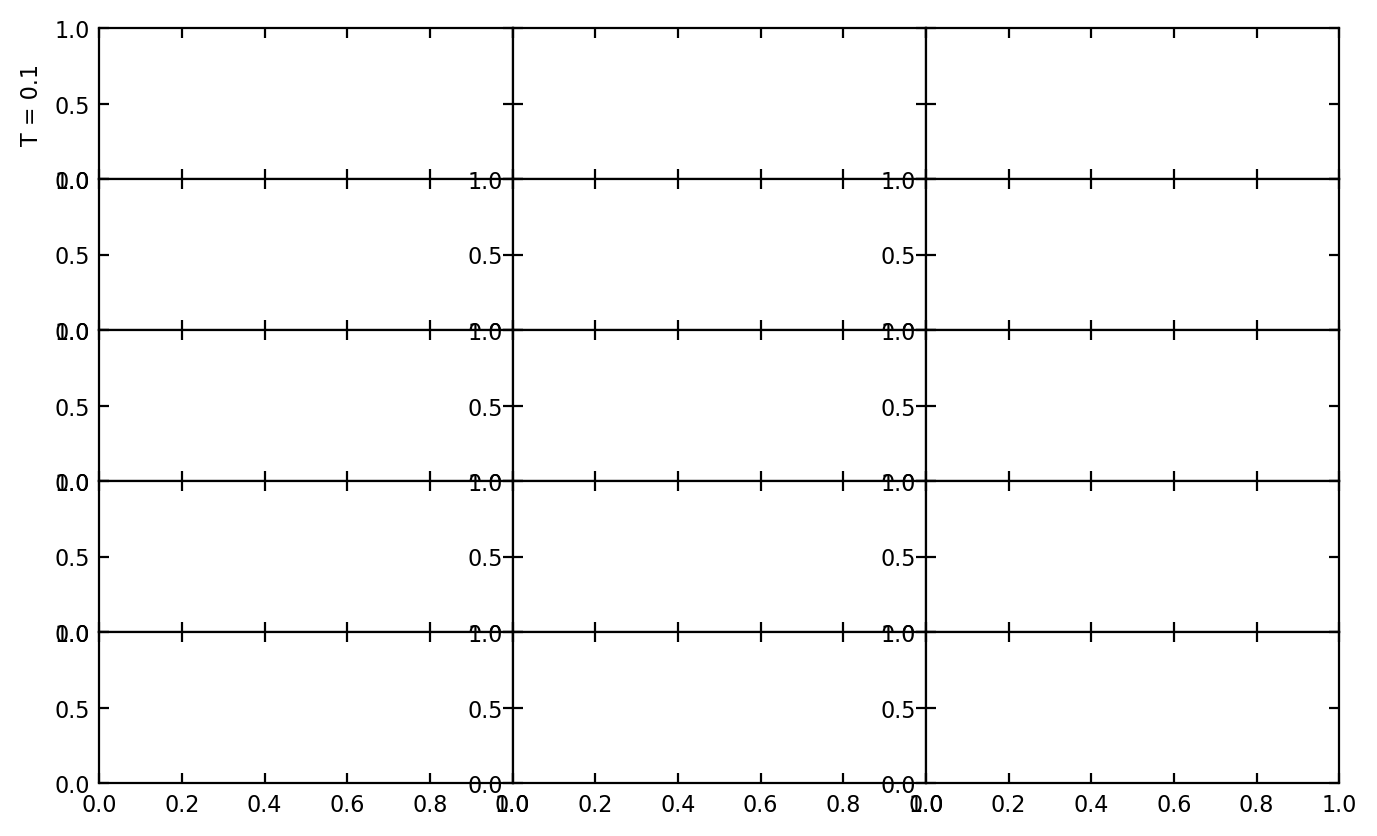

In [11]:
from itertools import count
o = o1
    
N = 3
T_is = np.arange(5)

f, rows = plt.subplots(len(T_is),3, sharex = 'all', 
                       #sharey = 'col',
                       figsize = (8, 1*len(T_is)), gridspec_kw = dict(hspace = 0, wspace = 0))

for T_i, axes in zip(T_is, rows):
    
    axes[0].set(ylabel = f'T = {o.Ts[T_i]:2g}')
    
    axes[1].tick_params(labelleft = False)
    axes[2].tick_params(labelleft = False)

    for i,N in enumerate(o.Ns): 
        spread(axes[0], o.E_bins[1:], o.DOS[i, T_i], o.dDOS[i, T_i], label = f'N = {N}')

    lines = [None for _ in o.Ns]
    for i,N in enumerate(o.Ns): 
        lines[i] = spread(axes[1], o.E_bins[1:], 
                          np.where( o.DOS[i, T_i] > 0.1, o.IPR[i, T_i], np.NaN),
                          o.dIPR[i, T_i],
                          label = f'N = {N}')
    if 'm' in o:
        spread(axes[2], o.E_bins[1:], 
                          np.where( o.DOS[-1, T_i] > 0.1, -o.m[T_i], np.NaN),
                          o.dm[T_i],
                          label = f'N = {N}')

    axes[0].set(xlim = (0,3))
    axes[2].set(ylim = (0,1))
    
f.legend(lines, labels = [f'N = {N}' for N in o.Ns])

/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater


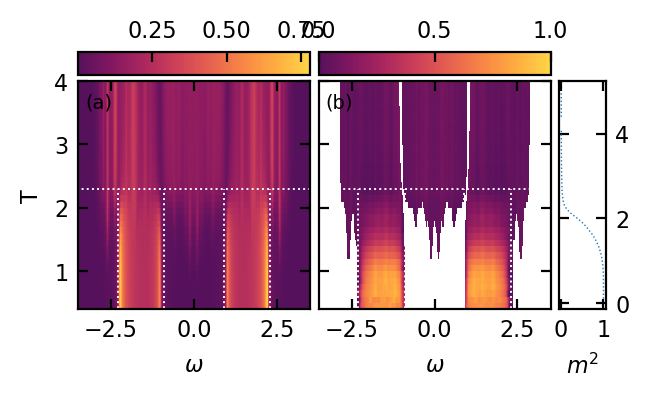

In [15]:
import pickle

with open('/home/tch14/HPC_data/pickled_data/gap_opening.pickle', 'rb') as file:
    o1 = pickle.load(file)
    
#with open('/home/tch14/HPC_data/pickled_data/gap_opening_low_temp.pickle', 'rb') as file:
#    o2 = pickle.load(file)

#with open('/home/tch14/HPC_data/pickled_data/gap_opening_low_temp2.pickle', 'rb') as file:
#    o3 = pickle.load(file)
    
os = [
    o1,
    #o2,
    #o3,
]

from FKMC.general import smooth

columnwidth = 246/72.27
width = columnwidth
height =  columnwidth / 2
dpi = 150

f, (caxes, axes) = plt.subplots(2,3, gridspec_kw = dict(wspace = 0.05, hspace = 0.05, height_ratios = (1,10), width_ratios = (5,5,1)))
caxes[-1].set(visible = False)    

#plot the E-T DOS Diagram

ax = axes[0]
#norm = mpl.colors.Normalize(vmin=0, vmax=1)

for o in os:
    axes[2].plot(o.Mf_moments.mean(axis = 1)[-1, :, 2], o.Ts, linewidth = 0.5, linestyle = 'dotted')

axes[2].set(xlabel = '$m^2$')


E_i = 2
for o in os:
    pcol = ax.pcolormesh(o.E_bins, o.Ts, o.DOS[-1], cmap=custom_cmap, linewidth=0, rasterized = True)

cbar = f.colorbar(pcol, cax = caxes[0], orientation="horizontal")
ax.set(ylabel = 'T', xlabel = '$\omega$', ylim = (0.1, 4), xlim = (-4, 4))
caxes[0].set_label(f'DOS (N = {o.Ns[E_i]})')

#plot the E-T IPR diagram Diagram
ax = axes[1]
norm = mpl.colors.Normalize(vmin=0, vmax=1)

for o in os:
    pcol = ax.pcolormesh(o.E_bins, o.Ts, np.where(o.DOS[-1] > 0.07, -o.m, np.NaN), norm = norm, cmap= custom_cmap, linewidth=0, rasterized = True)

f.colorbar(pcol, cax = caxes[1], orientation="horizontal")
ax.set(xlabel = '$\omega$', )

for a in axes[:2]: 
    a.tick_params(direction = "in")
    a.set(ylim = (0,4), xlim = (-3.5,3.5))
   
axes[1].tick_params(labelleft = False)
axes[-1].tick_params(labelleft = False, labelright = True)
    
for cax in caxes: cax.tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)
  
for label, ax in zip(["(a)","(b)"], axes):
    ax.text(0.03, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    
Tc = 2.3
for ax in axes[:2]:
    ax.hlines(y = Tc, xmin = -4, xmax = 4, linewidth = 0.7, linestyle = 'dotted', color = 'white')
    ax.vlines(x = [-2.3, -0.9, 0.9, 2.3], ymin = 0, ymax = Tc, linewidth = 0.7, linestyle = 'dotted', color = 'white')
    ax.set(ylim = (0.4,4))
    
f.subplots_adjust()
f.set_size_inches(width,height)

[1.         1.         1.         1.         0.99972369 0.99929988
 0.99715575 0.99269974 0.98442529 0.97218289 0.95453377 0.92810047
 0.90010319 0.855957   0.808848   0.75226481 0.67255045 0.59612157
 0.49972361 0.38406572 0.25349451 0.14912438 0.08241651 0.0548539
 0.04125824 0.03151733 0.02508207 0.02178143 0.01920998 0.01654869
 0.01554537 0.01427106 0.01282859 0.01217749 0.0115577  0.01096962
 0.01043891 0.00998221 0.00958951 0.00926538 0.00901141 0.00866966
 0.00850306 0.00820411 0.00811063 0.00761507 0.00747377 0.00749694
 0.00737271 0.00715538]
[0.99960979 1.         1.         0.99998819 0.99984768 0.99917714
 0.99720017 0.99262081 0.98478766 0.97165935]
o1.Ns = [ 60. 120. 270.]
o2.Ns = [ 60. 120. 270.]
o.Ts = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6
 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5. ]
o2.Ts = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


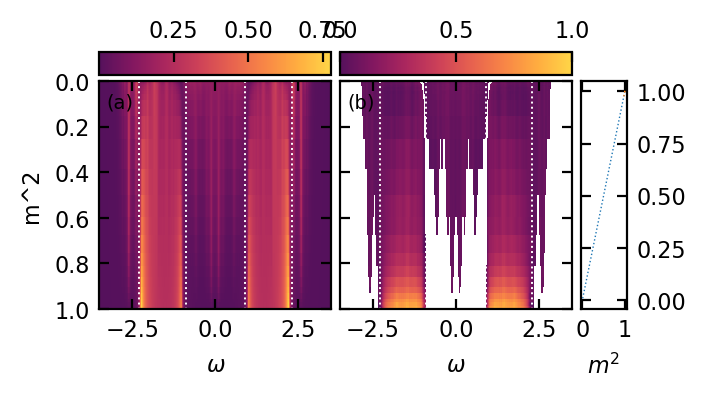

In [79]:
import pickle

with open('/home/tch14/HPC_data/pickled_data/gap_opening.pickle', 'rb') as file:
    o1 = pickle.load(file)
    
with open('/home/tch14/HPC_data/pickled_data/gap_opening_low_temp.pickle', 'rb') as file:
    o2 = pickle.load(file)
    
os = [
    o1,
    #o2,
]

from FKMC.general import smooth

columnwidth = 246/72.27
width = columnwidth
height =  columnwidth / 2
dpi = 150

f, (caxes, axes) = plt.subplots(2,3, gridspec_kw = dict(wspace = 0.05, hspace = 0.05, height_ratios = (1,10), width_ratios = (5,5,1)))
caxes[-1].set(visible = False)    

#plot the E-T DOS Diagram

ax = axes[0]
#norm = mpl.colors.Normalize(vmin=0, vmax=1)

for o in os:
    o.M2 = np.nanmean(o.Mf_moments, axis = 1)[-1, :, 2]
    axes[2].plot(o.M2, o.M2, linewidth = 0.5, linestyle = 'dotted')
    print(o.M2)
    
    
axes[2].set(xlabel = '$m^2$')
    
print(f'o1.Ns = {o1.Ns}')
print(f'o2.Ns = {o2.Ns}')
print(f'o.Ts = {o1.Ts}')
print(f'o2.Ts = {o2.Ts}')

E_i = 2
for o in os:
    pcol = ax.pcolormesh(o.E_bins, o.M2, o.DOS[-1], cmap=custom_cmap, linewidth=0, rasterized = True)

cbar = f.colorbar(pcol, cax = caxes[0], orientation="horizontal")
ax.set(ylabel = 'm^2', xlabel = '$\omega$', ylim = (0.1, 4), xlim = (-4, 4))
caxes[0].set_label(f'DOS (N = {o.Ns[E_i]})')

#plot the E-T IPR diagram Diagram
ax = axes[1]
norm = mpl.colors.Normalize(vmin=0, vmax=1)

for o in os:
    pcol = ax.pcolormesh(o.E_bins, o.M2, np.where(o.DOS[-1] > 0.07, -o.m, np.NaN), norm = norm, cmap= custom_cmap, linewidth=0, rasterized = True)

f.colorbar(pcol, cax = caxes[1], orientation="horizontal")
ax.set(xlabel = '$\omega$', )

for a in axes[:2]: 
    a.tick_params(direction = "in")
    a.set(ylim = (0,4), xlim = (-3.5,3.5))
   
axes[1].tick_params(labelleft = False)
axes[-1].tick_params(labelleft = False, labelright = True)
    
for cax in caxes: cax.tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)
  
for label, ax in zip(["(a)","(b)"], axes):
    ax.text(0.03, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    
Tc = 2.3
for ax in axes[:2]:
    ax.hlines(y = Tc, xmin = -4, xmax = 4, linewidth = 0.7, linestyle = 'dotted', color = 'white')
    ax.vlines(x = [-2.3, -0.9, 0.9, 2.3], ymin = 0, ymax = Tc, linewidth = 0.7, linestyle = 'dotted', color = 'white')
    ax.set(ylim = (1,0))
    
f.subplots_adjust()
f.set_size_inches(width,height)

In [ ]:
o.hints.IPR, o.IPR.shape

In [ ]:
np.random.randint(1,3)